In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from src.data import load_characters, load_movies
from src.utils.helpers import (
    filter_by_country, 
    drop_nans,
    drop_nans_subset,
    fix_date, 
    filter_by_language, 
    merge_movies_and_actors
)

characters = load_characters()

characters = drop_nans(characters, column="FreebaseActorId")

movies = load_movies()

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])


us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

us_movies = filter_by_language(us_movies, language="English Language")
us_characters_movies = merge_movies_and_actors(us_movies, characters)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


In [5]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30378, number of edges: 613672


#### Community Pairwise Stability Check

We will check the stability the following way: 
- We will make edges between all the nodes in one community in all runs
- Then we will take a random edge from some community of some run and calculate with which probability the same edge is present in a random run

We will run this procedure for $100$ times for each run

In [51]:
from src.utils.q_4_5.helpers import get_cooccurrences

cooccs_stats = []
for _ in tqdm(range(20)):
    cooccs_stats.append(get_cooccurrences(G_US))
cooccs_stats = np.array(cooccs_stats)
print(f'The probability of a pair of actors being in the same cluster again is about {cooccs_stats.mean()}, the std is {cooccs_stats.std()}')

  0%|          | 0/20 [00:00<?, ?it/s]

The probability of a pair of actors being in the same cluster again is about 0.73108, the std is 0.00944465986682422


We see that our calculations are statistically significant, we get that $3\sigma \leq 0.06$, so w.h.p the probability is $> 0.65$.

So we get that the pairwise relations of actors are stable after rerunning in more than $65\%$ of cases.

In [55]:
from src.utils.helpers import read_communities
from src.utils.graphs import Graph


communities_US = read_communities(G_US, "data/processed/new_communities_US_1.json")
communities_US_sorted = sorted(communities_US, key=lambda x: len(x), reverse=True)

graph_stats = Graph.init_from_list_of_lists(characters=characters,
                                            movies=us_movies,
                                            communities=communities_US_sorted)

Let's see the distribution of dates of release for clusters. We will look at clusters in the non-increasing order of size, we will only consider clusters with at least 50 movies.

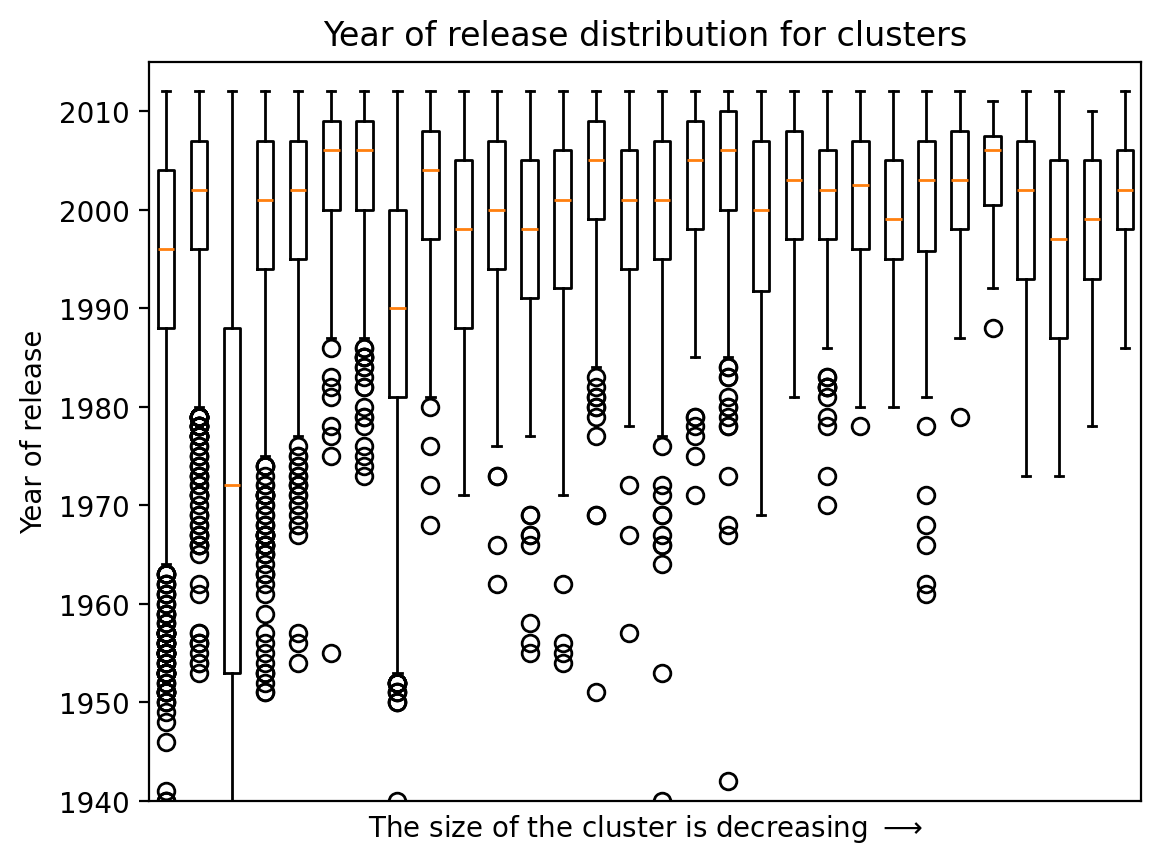

In [56]:
from src.utils.q_4_5.helpers import draw_year_distribution

cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies()["ReleaseDate"].apply(lambda x: int(x.year))
    if len(cluster_years) > 50:
        cluster_years_list.append(cluster_years)

draw_year_distribution(cluster_years_list)

We get that most of the clusters have high density and average around 2000. So, overall, clusters are not spread in time.

The same graph but considering a movie in a cluster if at least $50\%$ participated in it, we also consider clusters with at least $5$ movies.

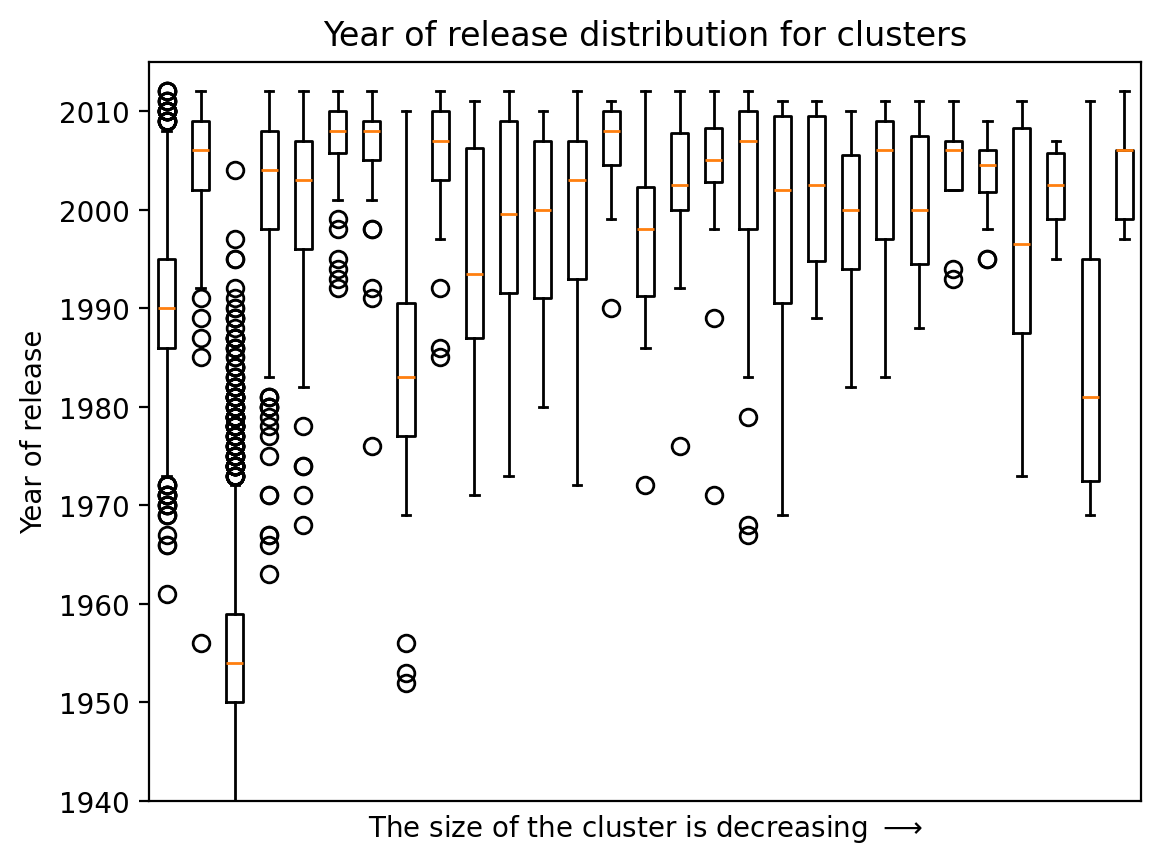

In [57]:
us_num_actors_in_movie = dict(us_characters_movies.groupby("WikipediaId").size())

cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie)["ReleaseDate"].apply(lambda x: int(x.year))
    if len(cluster_years) > 5:
        cluster_years_list.append(cluster_years)

draw_year_distribution(cluster_years_list)

We get similar results when comparing to the previous graph.